In [1]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz

%autoreload 2

In [2]:
import numpy as np
import os
import cProfile, pstats
from flatland.core.grid.grid4_astar import a_star

from flatland.core.grid.grid4_astar import set_priority
from flatland.core.grid.grid4_astar import get_priority


# In Flatland you can use custom observation builders and predicitors
# Observation builders generate the observation needed by the controller
# Preditctors can be used to do short time prediction which can help in avoiding conflicts in the network
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.line_generators import sparse_line_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

import matplotlib.pyplot as plt

In [15]:
width = 100 # With of map
height = 100  # Height of map
nr_trains = 2  # Number of trains that have an assigned task in the env
cities_in_map = 10# Number of cities where agents can start or end
seed = 20  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 5  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 5 # Max number of parallel tracks within a city, representing a realistic trainstation

In [16]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rail_pairs_in_city=max_rail_in_cities//2,
                                       )

In [17]:
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

In [18]:
line_generator = sparse_line_generator(speed_ration_map)

stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

observation_builder = GlobalObsForRailEnv()

from flatland.envs.malfunction_generators import Malfunction

class NoMalfunctionGenerator:
    def generate(self, np_random):
        return Malfunction(0)

class AlwaysThreeStepMalfunction:
    def generate(self, np_random):
        return Malfunction(3)

def test_waiting_no_transition():
    env = get_small_two_agent_env()
    env.malfunction_generator = NoMalfunctionGenerator()


In [19]:
env = RailEnv(width=width,
              height=height,
              rail_generator=rail_generator,
              line_generator=line_generator,
              number_of_agents=nr_trains,
              obs_builder_object=observation_builder,
              #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              malfunction_generator=ParamMalfunctionGen(stochastic_data),
              remove_agents_at_target=True,
              random_seed=seed)
env.reset(random_seed= seed);

In [13]:
set_priority(False)
profiler = cProfile.Profile()
profiler.enable() 
env.reset(random_seed= seed);
profiler.disable()
stats = pstats.Stats(profiler)
%snakeviz env.reset(random_seed=seed)

 
*** Profile stats marshalled to file '/tmp/tmps20q_ujr'.
Embedding SnakeViz in this document...
<function display at 0x7ff8b9638a60>


In [9]:

set_priority(True)

profiler = cProfile.Profile()
profiler.enable() 
env.reset(random_seed= seed);
profiler.disable()
stats = pstats.Stats(profiler)
%snakeviz env.reset(random_seed=seed)

 
*** Profile stats marshalled to file 'C:\\Users\\Robin\\AppData\\Local\\Temp\\tmpid5rzw7s'.
Embedding SnakeViz in this document...
<function display at 0x00000255433C3D90>


In [20]:
set_priority(True)
%lprun -f a_star env.reset(random_seed=seed)

Timer unit: 1e-09 s

Total time: 0.402273 s
File: /home/bob/EPFL/Bachelor_project/flatland-rl/flatland/core/grid/grid4_astar.py
Function: a_star at line 57

Line #      Hits         Time  Per Hit   % Time  Line Contents
    57                                           def a_star(grid_map: GridTransitionMap, start: IntVector2D, end: IntVector2D,
    58                                                      a_star_distance_function: IntVector2DDistance = Vec2d.get_manhattan_distance, avoid_rails=False,
    59                                                      respect_transition_validity=True, forbidden_cells: IntVector2DArray = None) -> IntVector2DArray:
    60                                               """
    61                                           
    62                                               :param avoid_rails:
    63                                               :param grid_map: Grid Map where the path is found in
    64                                               

In [21]:
def create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, 
               seed, grid_mode = False):
    nr_agent = 6
    stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train
    line_generator = sparse_line_generator(speed_ration_map)
    
    observation_builder = GlobalObsForRailEnv()
    
    rail_generator = sparse_rail_generator(max_num_cities=nr_cities,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rail_btw_cities,
                                       max_rail_pairs_in_city=max_rail_in_cities//2)
    env = RailEnv(width=width,
                  height=height,
                  rail_generator=rail_generator,
                  line_generator=line_generator,
                  number_of_agents=nr_agent,
                  obs_builder_object=observation_builder,
                  malfunction_generator=ParamMalfunctionGen(stochastic_data),
                  remove_agents_at_target=True,
                  random_seed=seed)
    return env

In [29]:
import time

def benchmark(priority):
    set_priority(priority)
    mean = 0
    count = 0
    if priority:
        print("BENCHMARK: A* | Datastructure: Heap\n")
    else:
        print("BENCHMARK: A* | Datastructure: OrderedSet\n")
    
    print("|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  ")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    for size in range(50, 200, 50):
        height = size
        width = size
        for nr_cities in range(4, 20, 2):
            count+=1
            #for max_rail_in_cities in range(1,6, 2):
            #    for max_rail_btw_cities in range(1,6, 2):
            max_rail_in_cities = 4
            max_rail_btw_cities = 10
            env = create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, 
            seed)
            time1= time.time()
            env.reset()
            time2 = time.time()
            delta = time2-time1
            mean += delta
            print(f"|  Parameters   |        {height}      |        {width}      |       {nr_cities}       |        {max_rail_in_cities}         |         {max_rail_btw_cities}        |        {delta}            ")


                
    print(f"------------------------------------------------------------------------------------------------------| Mean: {mean/count}")

        

In [23]:
def mean_given_param(height, width, nr_cities, max_rail_btw_cities, max_rail_in_cities, priority):
    mean = 0
    set_priority(priority)
    if priority:
        print("BENCHMARK: A* | Datastructure: Heap\n")
    else:
        print("BENCHMARK: A* | Datastructure: OrderedSet\n")
    
    print("|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  ")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")

        
    for i in range(10):                 
        env = create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, 
                        seed)
        time1= time.time()
        env.reset()
        time2 = time.time()
        delta = time2-time1
        print(f"|  Parameters   |        {height}      |        {width}      |       {nr_cities}       |        {max_rail_in_cities}         |         {max_rail_btw_cities}        |        {delta}            ")
        mean+=delta
    print(f"------------------------------------------------------------------------------------------------------| Mean: {mean/10}")
    

In [24]:
mean_given_param(200,200, 15, 8, 4, True)
print("----------------------------------------------------------------------------------------------------------------------------")
mean_given_param(200,200, 15, 8, 4, False)

BENCHMARK: A* | Datastructure: Heap

|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  
-------------------------------------------------------------------------------------------------------------------------------------------
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        1.775465488433838            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        1.3849117755889893            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        1.413003921508789            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        1.4647955894470215            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |    

In [30]:
benchmark(True)

print("-----------------------------------------------------------------------------------------------------------------------------------------------")
benchmark(False)

BENCHMARK: A* | Datastructure: Heap

|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  
-------------------------------------------------------------------------------------------------------------------------------------------
|  Parameters   |        50      |        50      |       4       |        4         |         10        |        0.2724177837371826            
|  Parameters   |        50      |        50      |       6       |        4         |         10        |        0.11963868141174316            
|  Parameters   |        50      |        50      |       8       |        4         |         10        |        0.705350399017334            
|  Parameters   |        50      |        50      |       10       |        4         |         10        |        0.1993393898010254            
|  Parameters   |        50      |        50      |       12       |        4         |         10        |        0.

In [26]:
env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=1020,  # Adjust these parameters to fit your resolution
                          screen_width=1800)

env.malfunction_generator = NoMalfunctionGenerator()

In [27]:
def show_env(env_renderer):
    env_renderer.render_env(show=False,  # whether to call matplotlib show() or equivalent after completion
                                show_agents=True,  # whether to include agents
                                show_inactive_agents=False,  # whether to show agents before they start
                                show_observations=True,  # whether to include observations
                                show_predictions=True,  # whether to include predictions
                                show_rowcols=True,  # label the rows and columns
                                frames=True,  # frame counter to show (intended since invocation)
                                episode=None,  # int episode number to show
                                step=None,  # int step number to show in image
                                selected_agent=None)  # indicate which agent is "selected" in the editor):
    plt.imshow(env_renderer.get_image())

/home/bob/EPFL/Bachelor_project/flatland-rl/flatland/utils/rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(
/home/bob/EPFL/Bachelor_project/flatland-rl/flatland/utils/rendertools.py:418: UserWarning: Predictor did not provide any predicted cells to render.                 Predictors builder needs to populate: env.dev_pred_dict
  warnings.warn(


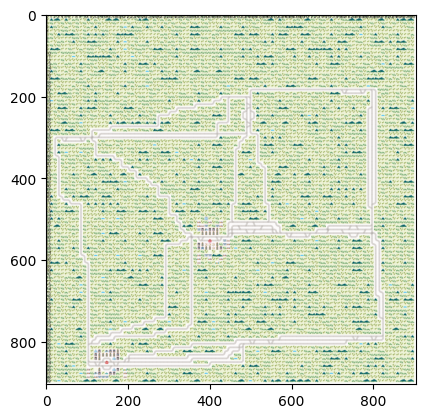

In [28]:
show_env(env_renderer)

In [20]:
print("Initial positions",  [a.initial_position for a in env.agents])
print("Initial directions", [a.initial_direction for a in env.agents])
print("Earliest Departures", [a.earliest_departure for a in env.agents])
print("Targets", [a.target for a in env.agents])
print("Speed Counter values", [a.speed_counter.max_count for a in env.agents])

Initial positions [(14, 20), (24, 6)]
Initial directions [1, 1]
Earliest Departures [15, 122]
Targets [(25, 6), (17, 20)]
Speed Counter values [2, 1]


In [21]:
def show_agents(env):
    for agent in env.agents:
        print(agent.handle, "Position", agent.position, "State", agent.state, end='\t')
    print()

In [22]:
for _ in range(max(a.earliest_departure for a in env.agents)+ 1):
    env.step({0: RailEnvActions.DO_NOTHING, 1: RailEnvActions.DO_NOTHING})
show_agents(env)

0 Position None State TrainState.READY_TO_DEPART	1 Position None State TrainState.READY_TO_DEPART	


0 Position (14, 20) State TrainState.MOVING	1 Position (24, 6) State TrainState.MOVING	
0 Position (14, 20) State TrainState.MOVING	1 Position (24, 6) State TrainState.MOVING	
0 Position (14, 20) State TrainState.MOVING	1 Position (24, 7) State TrainState.MOVING	
0 Position (14, 21) State TrainState.MOVING	1 Position (24, 7) State TrainState.MOVING	
0 Position (14, 21) State TrainState.MOVING	1 Position (24, 8) State TrainState.MOVING	
0 Position (14, 21) State TrainState.MOVING	1 Position (24, 8) State TrainState.MOVING	
0 Position (14, 22) State TrainState.MOVING	1 Position (23, 8) State TrainState.MOVING	
0 Position (14, 22) State TrainState.MOVING	1 Position (23, 8) State TrainState.MOVING	
0 Position (14, 22) State TrainState.MOVING	1 Position (23, 9) State TrainState.MOVING	


C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\utils\rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(
C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\utils\rendertools.py:418: UserWarning: Predictor did not provide any predicted cells to render.                 Predictors builder needs to populate: env.dev_pred_dict
  warnings.warn(


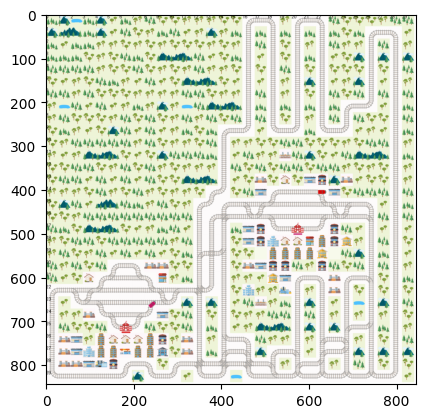

In [23]:
for _ in range(9):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.MOVE_FORWARD
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

In [ ]:
env.agents[1].malfunction_handler._set_malfunction_down_counter(100)
show_agents(env)
show_env(env_renderer)

In [ ]:
for _ in range(2):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.STOP_MOVING
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

In [ ]:
show_agents(env)

In [ ]:
action_dict = {}
action_dict[0] = RailEnvActions.MOVE_FORWARD
action_dict[1] = RailEnvActions.STOP_MOVING
env.step(action_dict);
show_agents(env)
show_env(env_renderer)

In [ ]:
import numpy as np
import os

from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.schedule_generators import sparse_schedule_generator


def get_small_two_agent_env():
    """Generates a simple 2 city 2 train env returns it after reset"""
    width = 30  # With of map
    height = 15  # Height of map
    nr_trains = 2  # Number of trains that have an assigned task in the env
    cities_in_map = 2 # Number of cities where agents can start or end
    seed = 42  # Random seed
    grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
    max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
    max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

    rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                        seed=seed,
                                        grid_mode=grid_distribution_of_cities,
                                        max_rails_between_cities=max_rails_between_cities,
                                        max_rail_pairs_in_city=max_rail_in_cities//2,
                                        )
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

    schedule_generator = sparse_schedule_generator(speed_ration_map)


    stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

    observation_builder = GlobalObsForRailEnv()

    env = RailEnv(width=width,
                height=height,
                rail_generator=rail_generator,
                schedule_generator=schedule_generator,
                number_of_agents=nr_trains,
                obs_builder_object=observation_builder,
                #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
                malfunction_generator=ParamMalfunctionGen(stochastic_data),
                remove_agents_at_target=True,
                random_seed=seed)

    env.reset()

    return env

In [ ]:
env = get_small_two_agent_env()

env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=600,  # Adjust these parameters to fit your resolution
                          screen_width=800)

i_agent = 1
ed = env.agents[i_agent].earliest_departure
for _ in range(ed):
    env.step({i_agent: RailEnvActions.DO_NOTHING})

show_agents(env)
show_env(env_renderer)

In [ ]:
for _ in range(50):
    env.step({i_agent: RailEnvActions.MOVE_FORWARD})

show_agents(env)
show_env(env_renderer)

In [ ]:
show_agents(env)
show_env(env_renderer)
